# Wetterstation Kloten

In [3]:
import numpy as np
import matplotlib.pyplot as plt

1. Import der Daten
   - Beschreibt die Datenstruktur.
   - Zeigt auf, wie viele Messungen es sind.

In [21]:
#load csv file
weather = np.loadtxt('Zürich21-22-GruppeG.csv', skiprows=1, delimiter=';', dtype=str)

#select data for Kloten
klo_weather = [row for row in weather if row[0] == 'KLO'] #klo_weather is a list of lists or Numpy array???


- #stn: Stationnummer oder ID der Wetterstation
- time: Zeitpunkt der Messung im Format JJJJMMDDhhmm
- prestah0: Luftdruck auf Stationshöhe (in hPa)
- tre200h0: Lufttemperatur in 2m Höhe (in Grad Celsius)
- rre150h0: Niederschlagssumme (in mm) der letzten 6 Minuten
- su2000h0: Sonnenscheindauer in Minuten der letzten Stunde
- time_diff: Zeitdifferenz zur vorigen Messung in Minuten

In [17]:

print("Anzahl Messungen:", len(klo_weather))

klo_weather_t = np.transpose(klo_weather)

#stn;time;prestah0;tre200h0;rre150h0;su2000h0;time_diff
#stn = klo_weather_t[0]
time = klo_weather_t[1]
prestah0 = klo_weather_t[2]
trew200h0 = klo_weather_t[3]
rre150h0 = klo_weather_t[4]
su2000h0 = klo_weather_t[5]
time_diff = klo_weather_t[6]

Anzahl Messungen: 7473


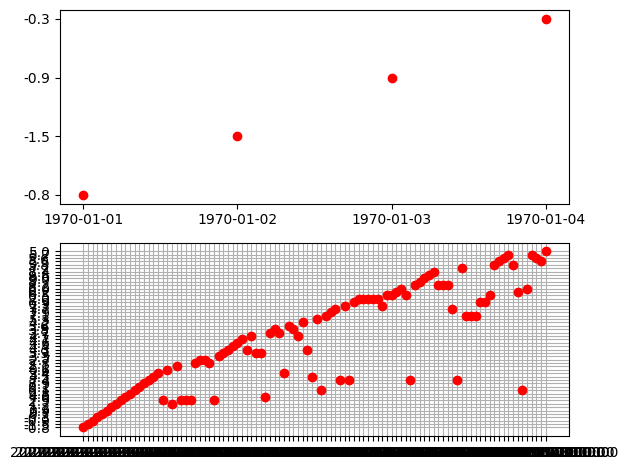

In [33]:
# Plots erstellen
""" plt.plot(time, prestah0)
plt.xlabel('Zeit')
plt.ylabel('Prestah0')
plt.show() """
""" plt.plot(time[200:204], trew200h0[200:204], "ro")
plt.xlabel('Zeit')
plt.ylabel('Luftdruck')
plt.legend()
plt.show() """



2. Da einige Datenpunkte fehlen, müsst ihr diese interpolieren.
   - Wählt dazu eine geeignete Methode und begründet eure Wahl.
   - Führt die Methode durch, um eine interpolierte Version der Daten mit mindestens doppelt so vielen Punkten zu erzeugen.

3. Ihr sollt alle Variablen (Luftdruck, Temperatur, Regenmenge und Sonnenstunden) über einen selbstgewählten Zeitraum darstellen. 
   - Basisvariante: Wähle einen interessanten Zeitraum von 1-2 Wochen.
   - Schwierigere Variante (mehr Punkte): Errechne tageweise Durchschnitte, um die Variablen in einem grösseren Zeitraum (mehrere Monate/Quartal) darzustellen.

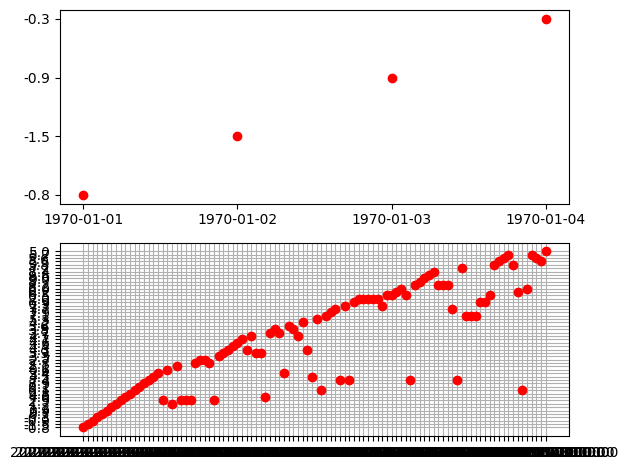

In [34]:
import matplotlib.dates as mdates

fig,(ax1, ax2) = plt.subplots(2, 1)
ax1.plot(time[200:204], trew200h0[200:204], "ro", label="Luftdruck")
date_fmt = mdates.DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_formatter(date_fmt)

ax2.plot(time[200:300], trew200h0[200:300], "ro", label="Luftdruck")
ax2.grid()

plt.tight_layout()
plt.show()